<div style="display: flex; align-items: center;">

  <a href="https://risklab.ai">
    <img src="https://raw.githubusercontent.com/RiskLabAI/Notebooks.py/3e53c22821f86ecf5120129f3a65ab47b7be3597/risklab_ai.gif" width="100px" style="margin-right: 20px; border: 0;"/>
  </a>
  
  <div>
    <h1 style="margin-bottom: 5px; margin-top: 1;">The Power of CPCV (`CombinatorialPurged`)
    </h1>     
    <a href="https://risklab.ai" style="font-size: 20px; text-decoration: none; color: #00ffffff;">
      RiskLab.ai
    </a>
  </div>
  
</div>

## 0. Setup and Imports

This setup is identical to the `PurgedKFold` tutorial for consistency.

In [5]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Third-party for data and modeling
import yfinance as yf
import ta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# RiskLabAI Imports
from RiskLabAI.backtest.validation import CrossValidatorController
import RiskLabAI.utils.publication_plots as pub_plots

# Setup plotting and configuration
pub_plots.setup_publication_style()
warnings.filterwarnings('ignore')

Matplotlib style updated for publication.


## 1. Load Data & Generate Signals

We use the same data generation as the previous tutorial to create our `X`, `y`, and `event_times`.

In [6]:
import yfinance as yf
import pandas as pd
import ta
from ta.utils import dropna

# --- 1. Load Data ---
ticker_symbol = "SPY"
start_date = "2010-01-01"
end_date = "2025-01-01"

data = yf.Ticker(ticker_symbol).history(
    start=start_date, 
    end=end_date, 
    auto_adjust=True
)

# --- FIX: Remove timezone information to prevent comparison errors ---
data.index = data.index.tz_localize(None)
# -------------------------------------------------------------------

# --- 2. Generate Features (X) ---
X = pd.DataFrame(index=data.index)
X['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
X['roc'] = ta.momentum.ROCIndicator(data['Close'], window=10).roc()

# --- 3. Generate Labels (y) ---
look_forward = 20
y = data['Close'].pct_change(look_forward).shift(-look_forward)
y = pd.Series((y > 0).astype(int), name='label')

# --- 4. Define Event Times (t1) ---
event_times = pd.Series(y.index, index=y.index).apply(lambda x: x + pd.DateOffset(days=look_forward))

# --- 5. Align Data ---
all_data = pd.concat([X, y, event_times.rename('t1')], axis=1).dropna()

X = all_data.drop(columns=['label', 't1'])
y = all_data['label']
event_times = all_data['t1']

print(f"--- SPY (ETF) Data Loaded (TZ-Naive) ---")
print(f"Aligned data shapes: X={X.shape}, y={y.shape}, t1={event_times.shape}")
print(X.head())

--- SPY (ETF) Data Loaded (TZ-Naive) ---
Aligned data shapes: X=(3761, 2), y=(3761,), t1=(3761,)
                  rsi       roc
Date                           
2010-01-22  27.005567 -4.361140
2010-01-25  31.250815 -4.189613
2010-01-26  29.721627 -4.724122
2010-01-27  33.672864 -3.369741
2010-01-28  29.364709 -5.278325


## 2. Running the CPCV Backtest

This is the core of the tutorial. Instead of manually looping, we will use the `backtest_predictions` method built into our cross-validators. This method is highly optimized and uses parallel processing.

We define:
* `n_splits = 10`: The data is split into 10 groups.
* `n_test_groups = 2`: Each test set will consist of 2 of these groups.

This will generate $C(10, 2) = 45$ total splits and, from those, $k=5$ backtest paths. (Note: $k$ is $n\_splits / n\_test\_groups$).


In [7]:
n_splits = 10
n_test_groups = 2
embargo_pct = 0.01

# --- 1. Instantiate the Validator ---
# We use the CrossValidatorController for easy creation.
cv_controller = CrossValidatorController(
    validator_type='combinatorialpurged',
    n_splits=n_splits,
    n_test_groups=n_test_groups,
    times=event_times,
    embargo=embargo_pct
)

cv = cv_controller.get_validator()

# --- 2. Define the Model ---
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# --- 3. Run All Backtest Paths --- 
print(f"Running Combinatorial Backtest... (This may take a moment)")

# This single call runs all C(n,k) training jobs and assembles all paths.
# n_jobs=-1 will parallelize the training of the 45 estimators.
paths_predictions = cv.backtest_predictions(
    estimator=model,
    data=X,
    labels=y,
    n_jobs=-1
)

print(f"Backtest complete.")
print(f"Received {len(paths_predictions)} backtest paths.")
print(f"Keys: {list(paths_predictions.keys())}")

Running Combinatorial Backtest... (This may take a moment)
Backtest complete.
Received 9 backtest paths.
Keys: ['Path 1', 'Path 2', 'Path 3', 'Path 4', 'Path 5', 'Path 6', 'Path 7', 'Path 8', 'Path 9']


## 3. Evaluate the Distribution of Performance

This is the "Aha!" moment. `paths_predictions` is not a single array, but a **dictionary** where each key is a path ID and each value is the OOS prediction array for that path.

We can now calculate the accuracy for *each path* and see the full distribution of our model's performance.

In [9]:
path_accuracies = []

print("Calculating accuracy for each path...")
for path_name, predictions in paths_predictions.items():
    
    # The 'predictions' array is already aligned with the 'y' Series
    # because the CPCV splits are sequential.
    
    # Calculate accuracy
    acc = accuracy_score(y, predictions) # <-- This is the corrected line
    
    path_accuracies.append(acc)
    print(f"  {path_name}: Accuracy = {acc * 100:.2f}%")

path_accuracies = pd.Series(path_accuracies)

Calculating accuracy for each path...
  Path 1: Accuracy = 60.28%
  Path 2: Accuracy = 60.33%
  Path 3: Accuracy = 59.80%
  Path 4: Accuracy = 60.57%
  Path 5: Accuracy = 59.85%
  Path 6: Accuracy = 60.09%
  Path 7: Accuracy = 60.57%
  Path 8: Accuracy = 62.22%
  Path 9: Accuracy = 60.65%


## 4. Visualize the Results

Now we plot the histogram of our path accuracies. This tells us far more than a single score.

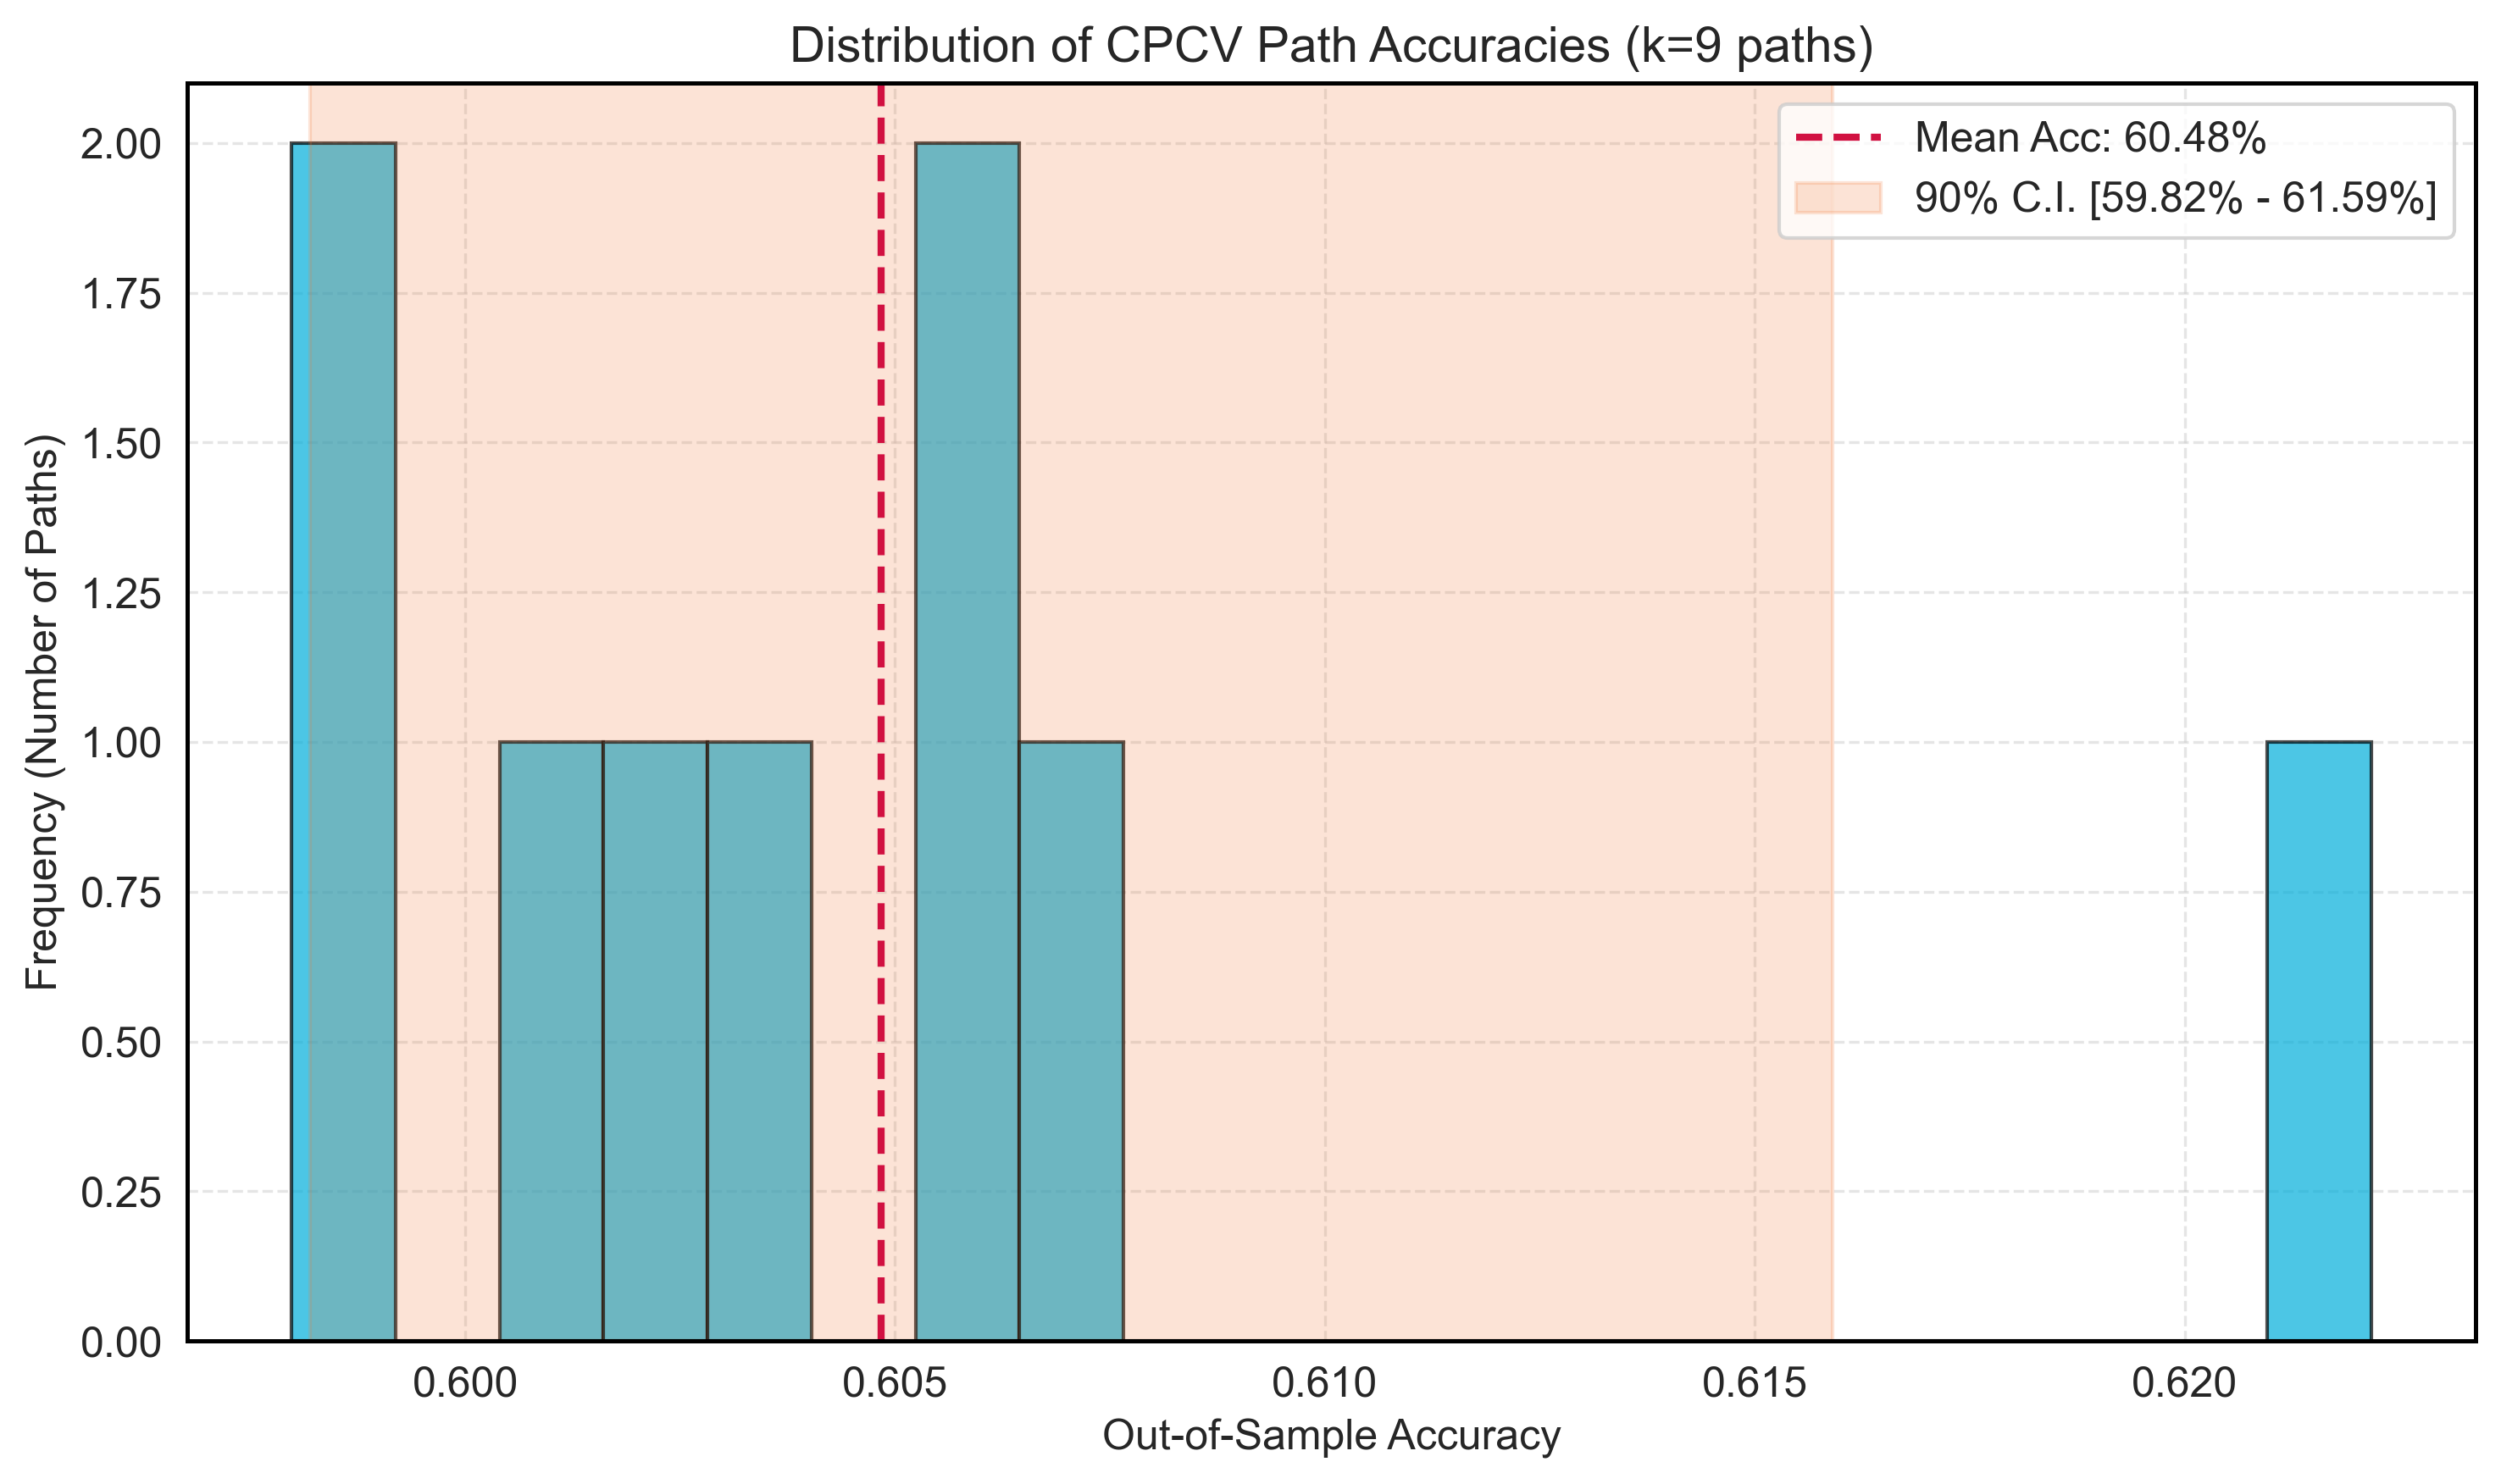

Summary Statistics:
Mean Accuracy: 60.48%
Std. Dev:      0.72%
Min Accuracy:  59.80%
Max Accuracy:  62.22%


In [10]:
mean_acc = path_accuracies.mean()
std_acc = path_accuracies.std()
p5 = path_accuracies.quantile(0.05)
p95 = path_accuracies.quantile(0.95)

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(path_accuracies, bins=20, alpha=0.7, color='#00aedb', edgecolor='black')

ax.axvline(mean_acc, color='#d11141', linestyle='--', lw=2, 
             label=f'Mean Acc: {mean_acc*100:.2f}%')
             
ax.axvspan(p5, p95, color='#f37735', alpha=0.2, 
             label=f'90% C.I. [{p5*100:.2f}% - {p95*100:.2f}%]')

ax.set_xlabel('Out-of-Sample Accuracy')
ax.set_ylabel('Frequency (Number of Paths)')
ax.set_title(f'Distribution of CPCV Path Accuracies (k={len(path_accuracies)} paths)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Summary Statistics:")
print(f"Mean Accuracy: {mean_acc*100:.2f}%")
print(f"Std. Dev:      {std_acc*100:.2f}%")
print(f"Min Accuracy:  {path_accuracies.min()*100:.2f}%")
print(f"Max Accuracy:  {path_accuracies.max()*100:.2f}%")